Imports

In [201]:
import os
import cv2
import glob

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Image show

In [ ]:
def imshow(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
  if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() 

Image read

In [204]:
image_dict = {}

for direct in sorted(glob.glob('./data/image/*.png')):
    name = os.path.basename(direct)
    prefix = name.split('_')[0]

    img = cv2.imread(direct, cv2.IMREAD_GRAYSCALE)
    
    if prefix in image_dict:
        image_dict[prefix].append((img))
    else:
        image_dict[prefix] = [(img)]

In [205]:
image_sample = cv2.imread('./sample.png', cv2.IMREAD_GRAYSCALE)
image_sample = cv2.resize(image_sample, (np.array(image_sample.shape)//4)[::-1])


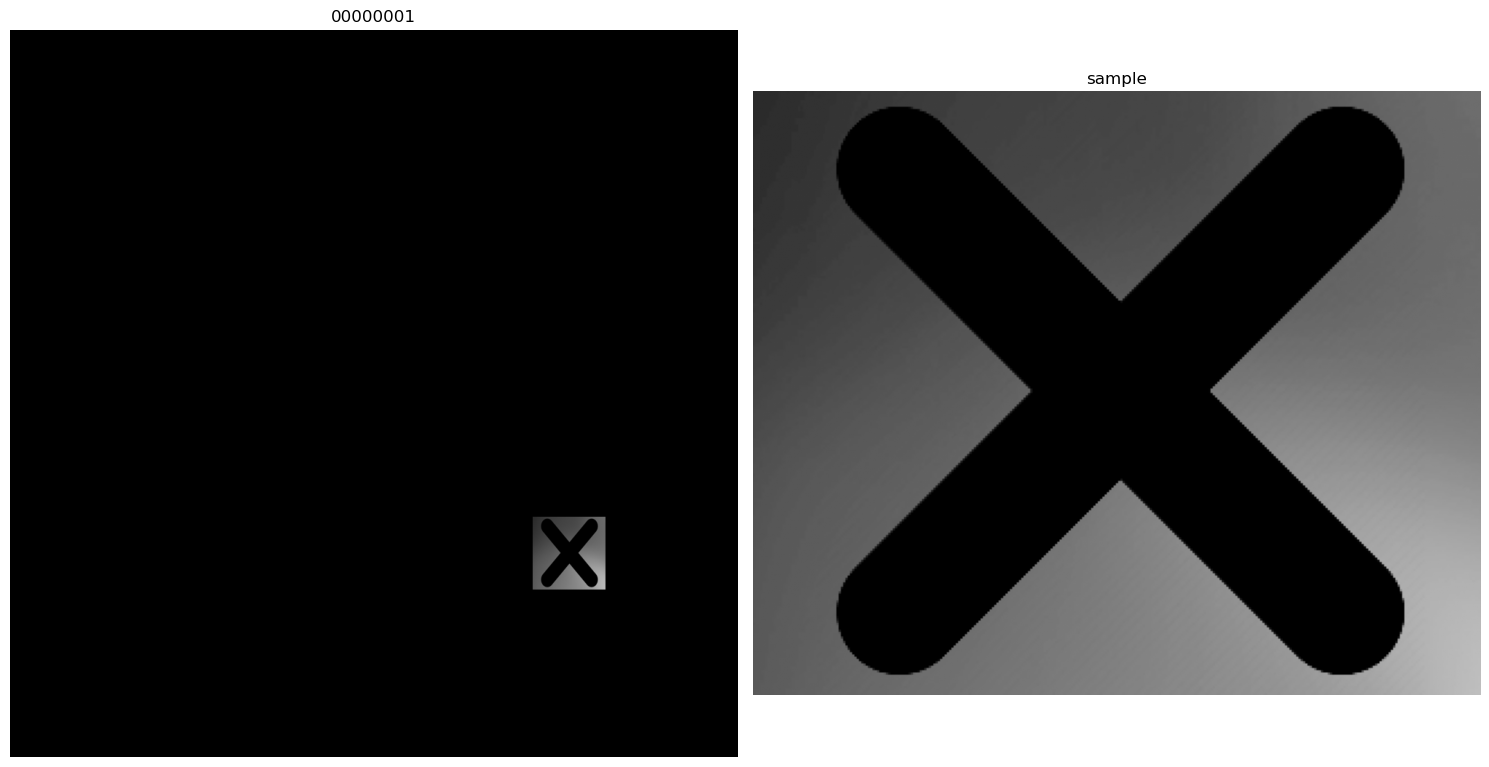

In [206]:
imshow([image_dict['00000001.png'][0], image_sample], ['00000001', "sample"])

# out data

In [153]:
data_out = []

# 0-300

In [ ]:
def find_centers(img):

    # бинаризация изображения
    _, thresh = cv2.threshold(img, 40, 255, cv2.THRESH_BINARY)

    # поиск контуров
    # cv2.RETR_EXTERNAL - внешних контуров
    # cv2.CHAIN_APPROX_SIMPLE - упрощения контуров
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    centers = []
    for cnt in contours:
        # вычисление моментов контура
        M = cv2.moments(cnt)
        # вычисление центра
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centers.append((cx, cy))

    return centers

Point (191, 640)


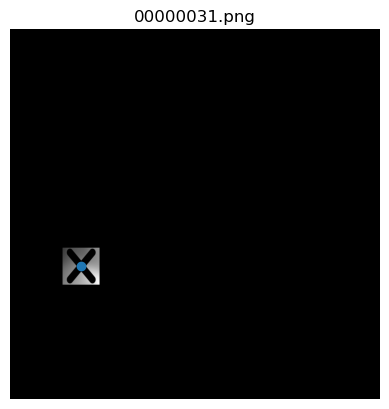

Point (340, 629)


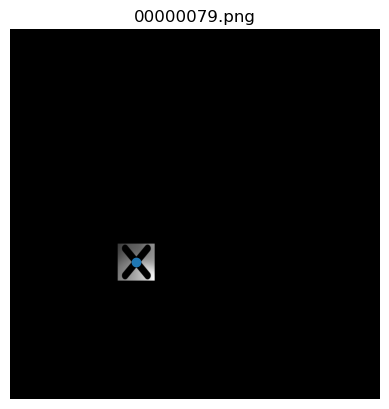

Point (857, 918)


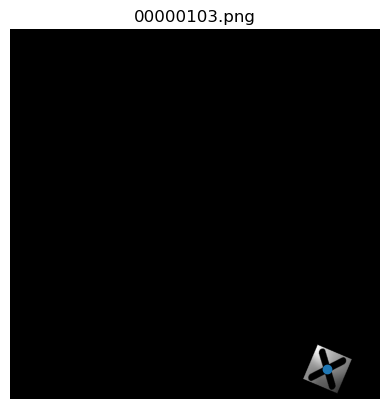

Point (302, 841)
Point (897, 347)


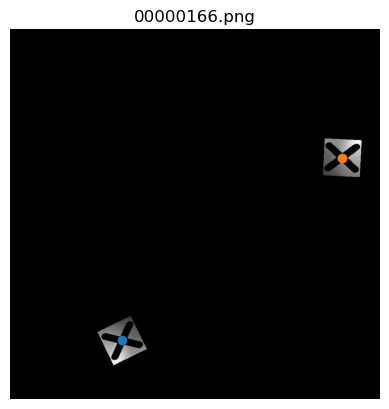

Point (643, 764)
Point (797, 406)
Point (979, 329)


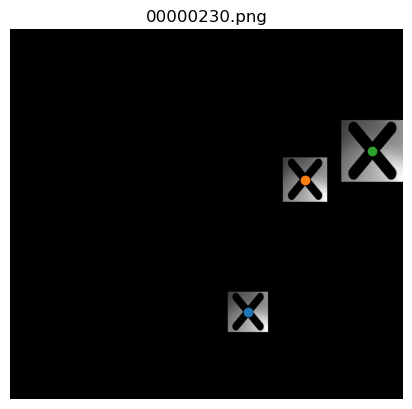

Point (330, 493)


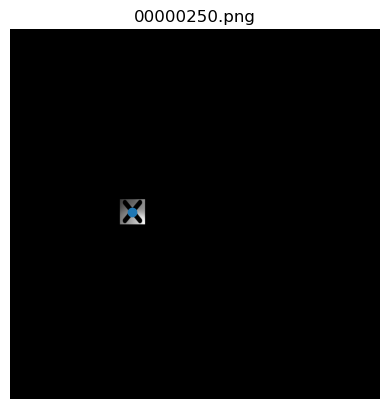

Point (333, 669)
Point (635, 125)


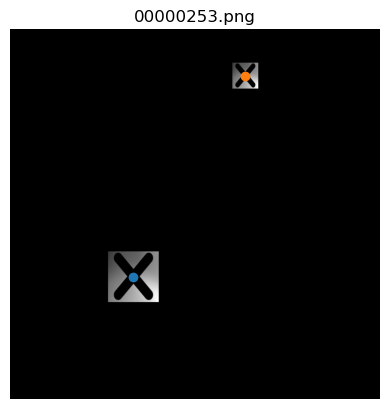

Point (861, 616)
Point (718, 368)


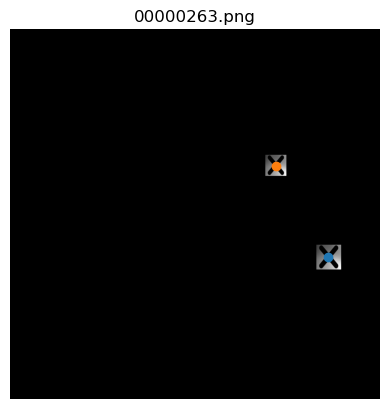

Point (580, 867)
Point (534, 136)


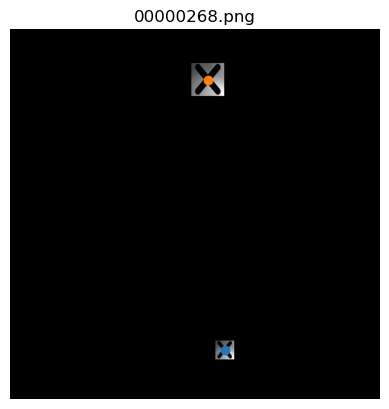

Point (57, 49)


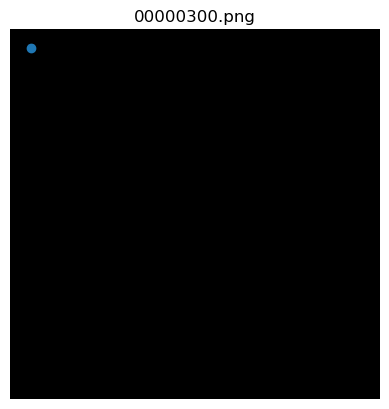

In [141]:
index = list(image_dict.keys())
for ind in sorted((np.random.sample((10))*300%300).astype(int)):
    center = find_centers(image_dict[index[ind]][0])
    plt.title(index[ind])
    plt.axis('off')
    plt.imshow(image_dict[index[ind]][0])

    for box in center:
        print(f'Point ({box[0]}, {box[1]})')
        plt.scatter(box[0], box[1])
    plt.show()

In [154]:
index = list(image_dict.keys())
for ind in range(300):
    center = find_centers(image_dict[index[ind]][0])

    data_out.append({
        'image': index[ind],
        'n_box': len(center),
        'centers': center
    })

# 300 - 400

## Свертка

In [162]:
def filter2D(img, kernel):
    img = cv2.filter2D(img, -1, kernel)
    cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    return img

### Тесты ядер

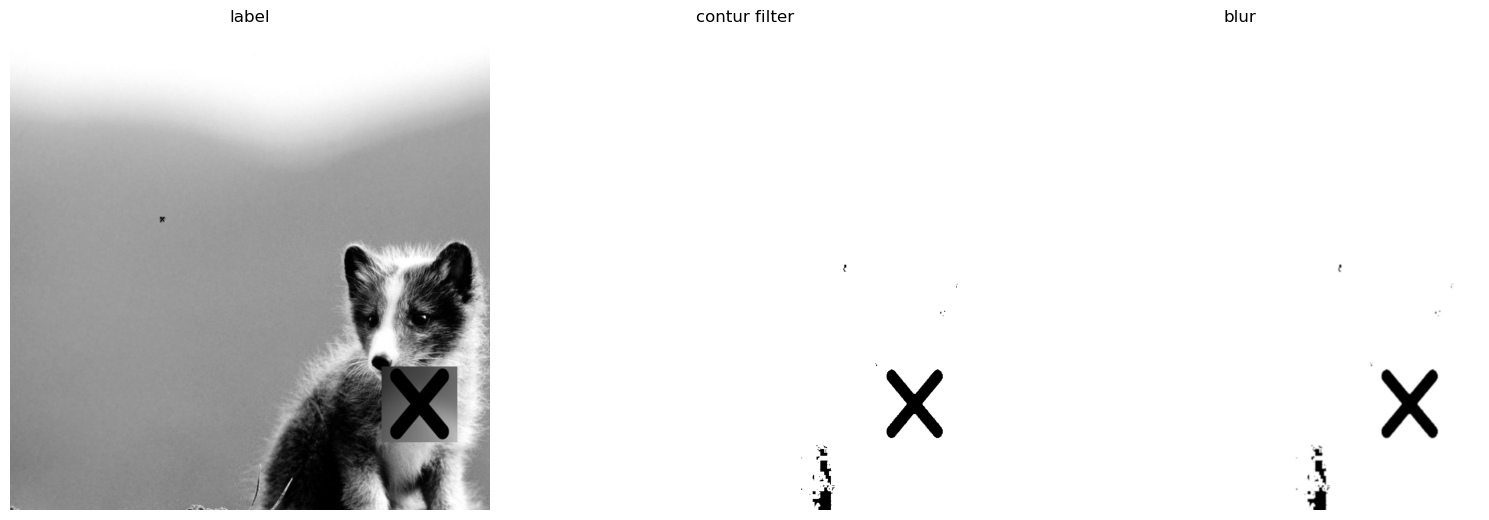

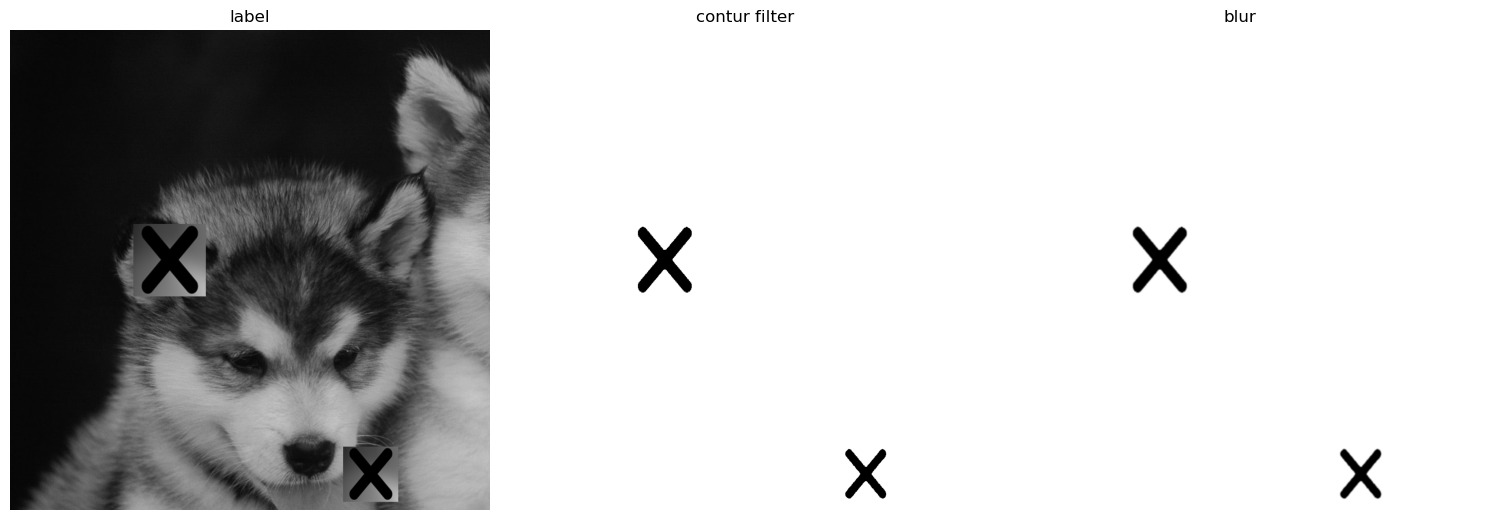

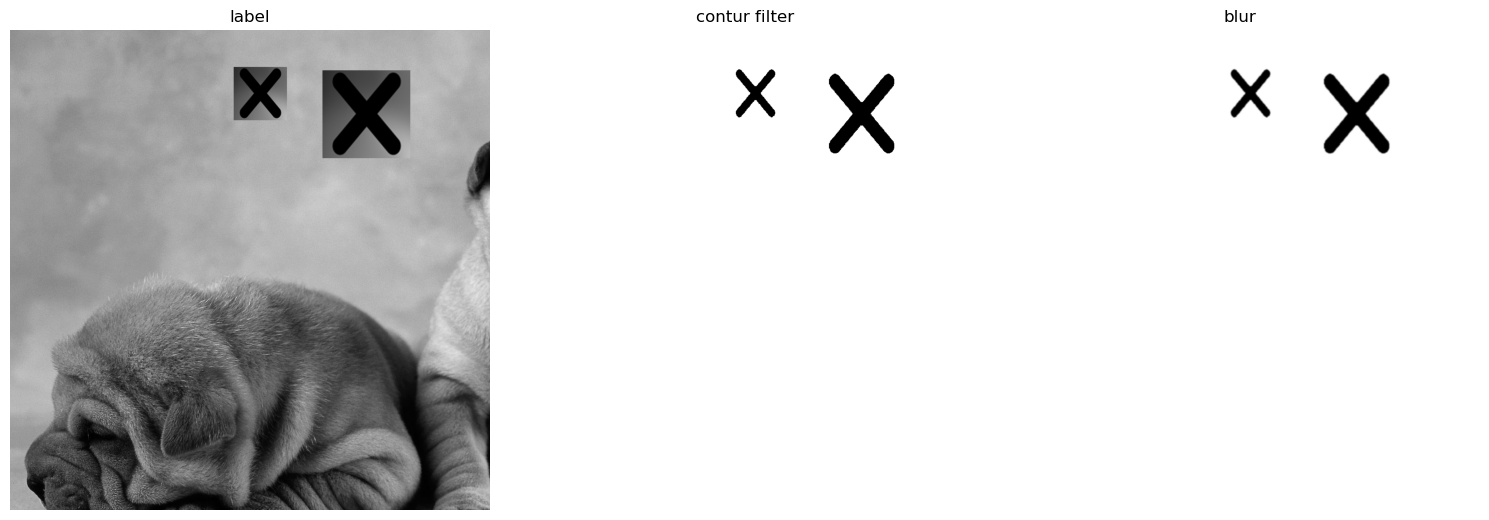

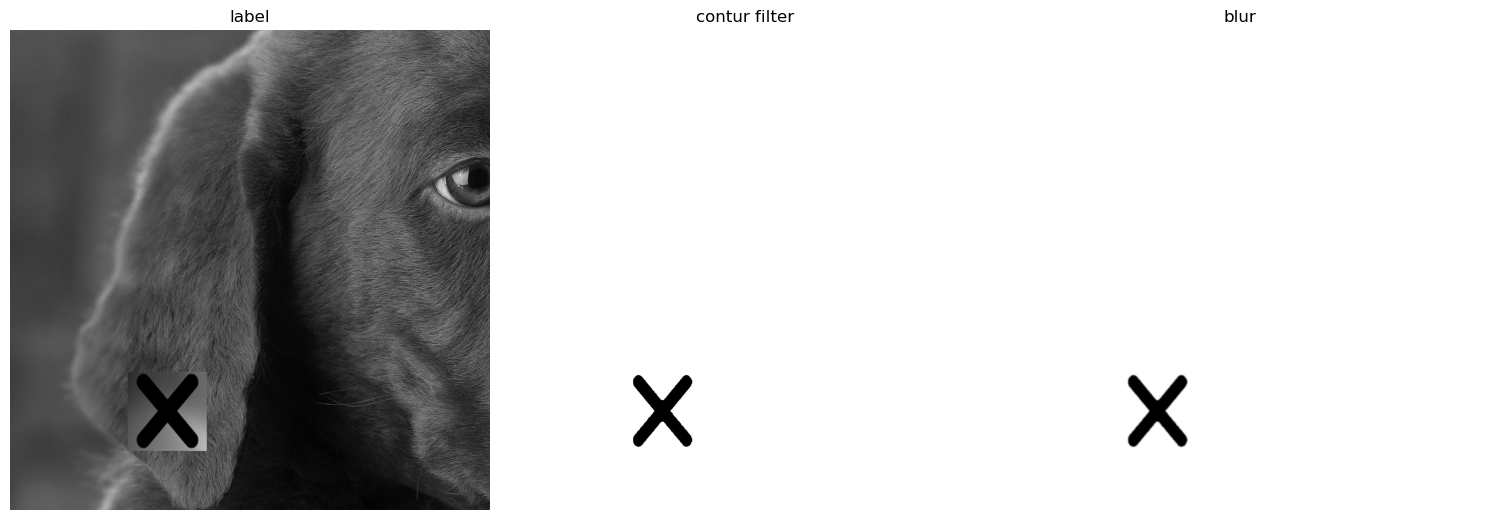

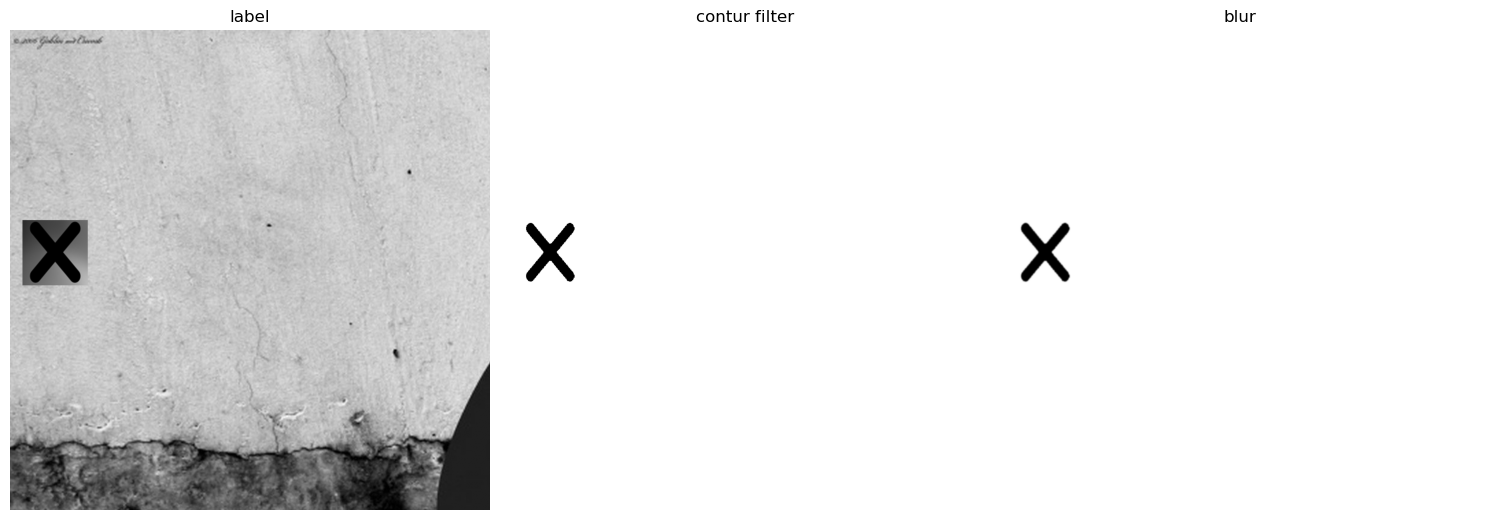

In [163]:
index = list(image_dict.keys())
for ind in sorted((np.random.sample((5))*100%100+300).astype(int)):
    img = image_dict[index[ind]][0]
    img_red = []

    kernel = np.array(
        [
            [1,1,1],
            [1,0,1],
            [1,1,1]
        ]
    )* 255
    img_red.append(filter2D(img, kernel))

    img_red.append(cv2.GaussianBlur(img_red[-1], (5, 5), 0))

    imshow([img, img_red[0], img_red[1]], ['label', 'contur filter', 'blur'])

In [ ]:
def find_black_x_on_white(image_path, x_template_path, match_threshold=0.7, scales=None):
    img = image_path
    template_orig = x_template_path

    kernel = np.array(
        [
            [1,1,1],
            [1,0,1],
            [1,1,1]
        ]
    )* 255

    # свертка изображения
    img = filter2D(img, kernel)

    # размытие по гаусу
    img = cv2.GaussianBlur(img, (5, 5), 0)

    # веса изменения маштаба
    if scales is None:
        scales = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]

    # создание SIFT
    sift = cv2.SIFT_create()
    centers = []

    # проход по масштабам
    for scale in scales:
        
        # маштабирование
        template = cv2.resize(template_orig, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        h, w = template.shape

        # проверка на минимальный и максимальный размер
        if h < 5 or w < 5 or h > 10+img.shape[0] or w > 10+img.shape[1]:
            continue

        # поиск совпадения с шаблоном
        res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= match_threshold)

        # поиск ключевых точек и дескрипторов
        kp1, des1 = sift.detectAndCompute(template, None)
        if des1 is None:
            continue

        # проходим по участкам изображения, где найдено совпадение
        for pt in zip(*loc[::-1]):
            # получаем участок
            roi = img[pt[1]:pt[1]+h, pt[0]:pt[0]+w]
            if roi.shape[0] < h or roi.shape[1] < w:
                continue

            # поиск ключевых точек и дескрипторов участка
            kp2, des2 = sift.detectAndCompute(roi, None)
            if des2 is None:
                continue

            # сопоставление дескрипторов
            bf = cv2.BFMatcher()
            matches = bf.knnMatch(des1, des2, k=2)
            
            # фильтрация совпадений
            good = []
            for match in matches:
                if len(match) == 2:
                    m, n = match
                    if m.distance < 0.7 * n.distance:
                        good.append(m)
            if len(good) < 4:
                continue

            # вычисление центра найденного шаблона
            center_x = pt[0] + w // 2
            center_y = pt[1] + h // 2
            
            # проверка на близость к уже найденным центрам
            centers.append((center_x, center_y)) if not any(np.sqrt((center_x - cx) ** 2 + (center_y - cy) ** 2) < 25 for cx, cy in centers) else None

    return centers


(-0.5, 80.5, 89.5, -0.5)

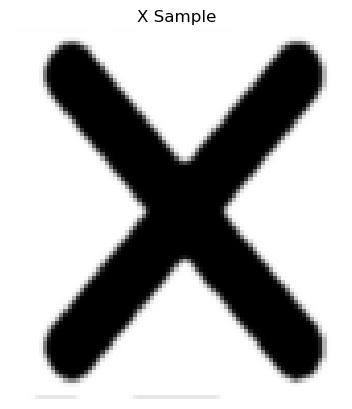

In [165]:
x_sample = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(x_sample, cmap='gray')
plt.title('X Sample')
plt.axis('off')

Point (320, 188)


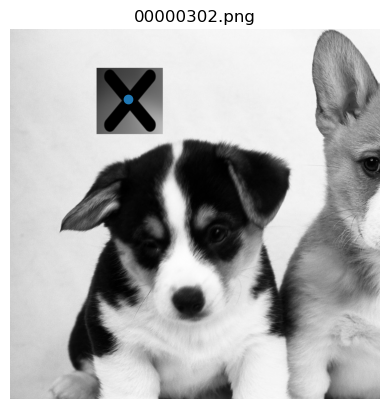

Point (30, 120)
Point (663, 826)


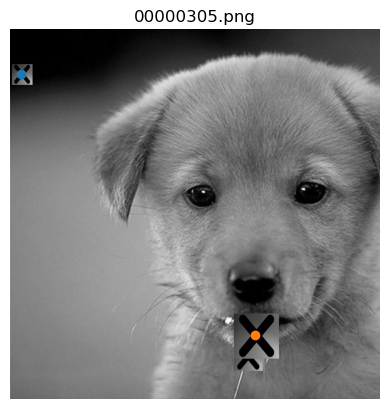

Point (645, 585)


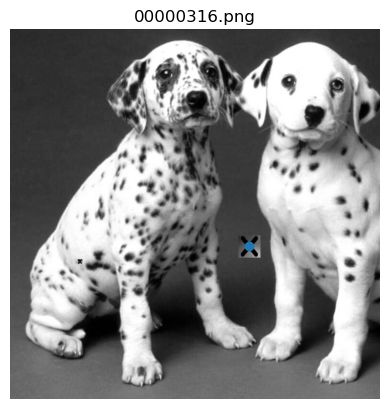

Point (284, 429)
Point (361, 102)


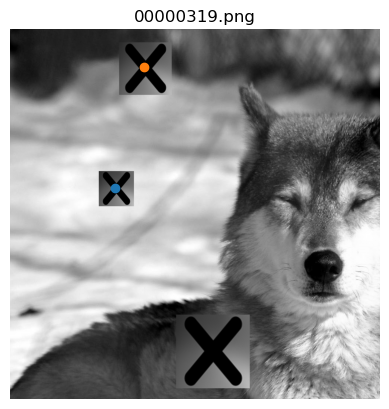

Point (442, 788)
Point (43, 900)


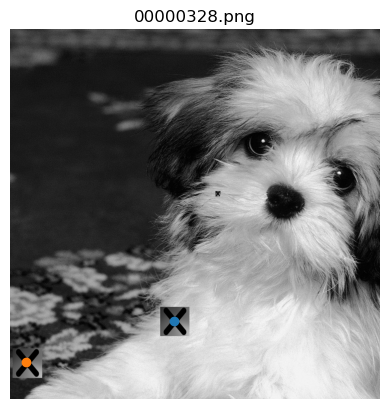

Point (764, 117)


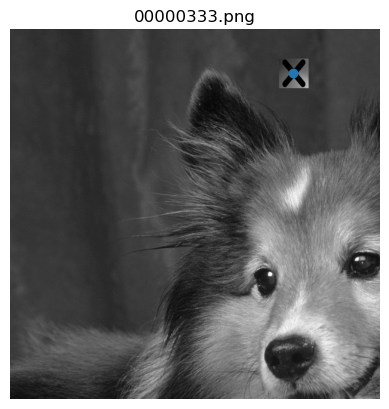

Point (303, 166)


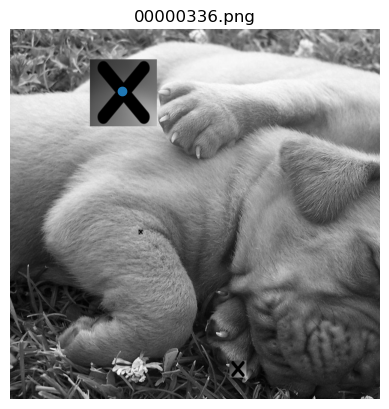

Point (529, 457)
Point (787, 151)


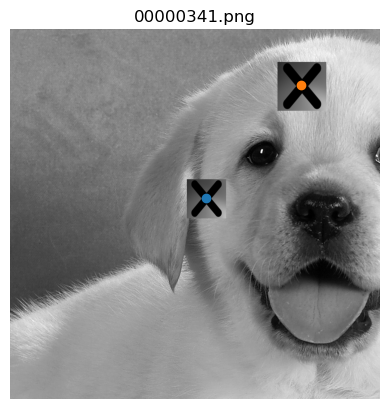

Point (785, 338)


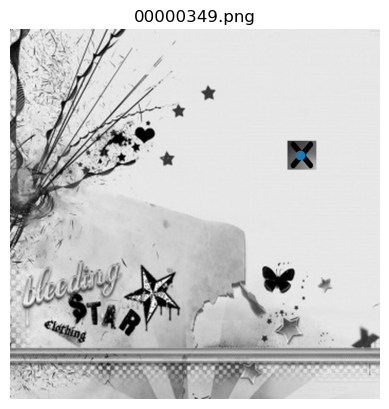

Point (488, 140)


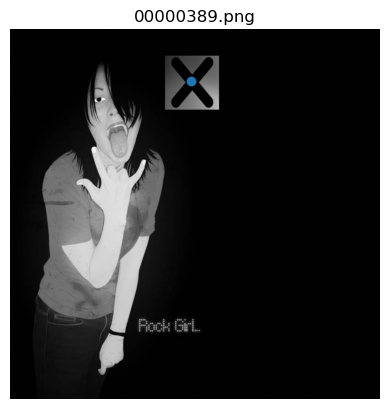

In [166]:
index = list(image_dict.keys())
for ind in sorted((np.random.sample((10))*100%100+300).astype(int)):
    img = image_dict[index[ind]][0]
    
    center = find_black_x_on_white(img, x_sample)
    plt.title(index[ind])
    plt.axis('off')
    plt.imshow(image_dict[index[ind]][0])

    for box in center:
        print(f'Point ({box[0]}, {box[1]})')
        plt.scatter(box[0], box[1])
    plt.show()

In [171]:
index = list(image_dict.keys())
for ind in range(300, 400):
    img = image_dict[index[ind]][0]
    
    center = find_black_x_on_white(img, x_sample)

    data_out.append({
        'image': index[ind],
        'n_box': len(center),
        'centers': center
    })

Point (365, 657)


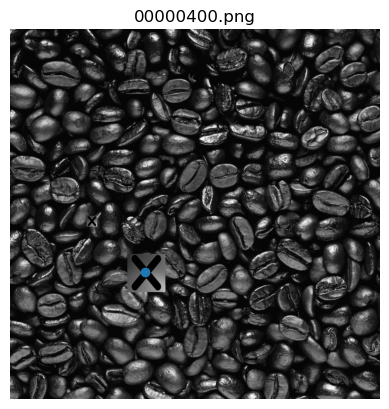

In [174]:
index = list(image_dict.keys())
if True:
    ind = 399
    img = image_dict[data_out[ind]['image']][0]
    
    plt.title(data_out[ind]['image'])
    plt.axis('off')
    plt.imshow(img)

    for box in data_out[ind]['centers']:
        print(f'Point ({box[0]}, {box[1]})')
        plt.scatter(box[0], box[1])
    plt.show()

In [175]:
out_file = pd.DataFrame(data_out)

In [177]:
out_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    400 non-null    object
 1   n_box    400 non-null    int64 
 2   centers  400 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


In [178]:
out_file.to_csv('data_out.csv', index=False)

In [179]:
data = data_out.copy()

In [184]:
data = np.array(data)

In [196]:
data = list(
    map(
        lambda x:
        {
            'name': x['image'],
            'numOfObj': x['n_box'],
            'dots': '['+'; '.join([f"{cx}, {cy}" for cx, cy in x['centers']])+']'
        },
        data
    )
)

In [197]:
out_file = pd.DataFrame(data)

In [198]:
out_file

,name,numOfObj,dots
0,00000001.png,1,"[767, 719]"
1,00000002.png,3,"[156, 924; 905, 621; 787, 515]"
2,00000003.png,3,"[109, 917; 337, 441; 169, 169]"
3,00000004.png,3,"[417, 936; 896, 520; 252, 382]"
4,00000005.png,2,"[282, 437; 461, 288]"
...,...,...,...
395,00000396.png,1,"[918, 532]"
396,00000397.png,2,"[619, 603; 491, 763]"
397,00000398.png,2,"[454, 509; 660, 584]"
398,00000399.png,1,"[918, 710]"


In [200]:
out_file.to_excel('data_out.xlsx', index=False)